In [85]:
# Import libraries to be used.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

In [86]:
# Define a random state value
RANDOM_STATE = 3030

In [87]:
# Define column names which will be used instead of the ones in the datasets.
column_names = [
    "age", "sex", "chest_pain_type", "rest_bp", "cholesterol",
    "fasting_bs", "resting_ecg", "max_hr", "exercise_angina", "st_exercise_depression",
    "st_exercise_slope", "major_vessels_fluorospy", "thal", "angiographic_disease"
]
na_values = ["?"] # Define what values will be interpreted as missing values, in this dataset the "?" character is used for this.

# Load all datasets using relative paths and combine into one dataframe.
df = pd.concat([
    pd.read_csv("../data/processed.cleveland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.hungarian.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.switzerland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.va.data", names=column_names, na_values=na_values)
]).drop(['st_exercise_slope', 'major_vessels_fluorospy', 'thal'], axis=1)

In [88]:
df[df["angiographic_disease"] > 1] = 1

In [89]:
df['age'].fillna((df['age'].mean()), inplace=True)
df['rest_bp'].fillna((df['rest_bp'].mean()), inplace=True)
df['cholesterol'].fillna((df['cholesterol'].mean()), inplace=True)
df['max_hr'].fillna((df['max_hr'].mean()), inplace=True)
df['st_exercise_depression'].fillna((df['st_exercise_depression'].mean()), inplace=True)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [90]:
# Set category attributes
df["sex"] = df["sex"].astype("category")
df["chest_pain_type"] = df["chest_pain_type"].astype("category")
df["fasting_bs"] = df["fasting_bs"].astype("category")
df["resting_ecg"] = df["resting_ecg"].astype("category")
df["exercise_angina"] = df["exercise_angina"].astype("category")
df["angiographic_disease"] = df["angiographic_disease"].astype("category")

In [91]:
df_X = df.drop(["angiographic_disease"], axis=1)

In [92]:
X = MinMaxScaler().fit_transform(df_X.to_numpy())
Y = df["angiographic_disease"].to_numpy()

In [93]:
def evaluate_model(estimator, params, estimator_name):
    print("******** STARTING TRAINING AND EVALUATION OF {} ********".format(estimator_name))
    evaluation_results = {}
    calculated_scores = []
    SCORERS = ["roc_auc", "f1_macro", "accuracy", 'recall', 'precision', 'jaccard']
    CV_K = 10

    for i in range(0, 5):
        n_features = 2*(i+1)
        # Find the best k features
        select_k_best = SelectKBest(chi2, k=n_features).fit(X, Y)
        X_new = select_k_best.transform(X)

        # Perform grid search to find the best estimator for this feature set
        clf = GridSearchCV(estimator=estimator, param_grid=params, refit=False)
        clf.fit(X_new, Y)
        best_estimator = clone(estimator).set_params(**clf.best_params_)

        index_name = "{}_features".format(n_features)
        selected_features = select_k_best.get_feature_names_out(input_features=df_X.columns)
        evaluation_results[index_name] = {"scores": {}, "features": selected_features, "best_hyperparameters": clf.best_params_}

        print("Running {}-CV with features={}, estimator={}".format(CV_K, selected_features, best_estimator))

        # Perform cross-validation in order to evaluate the best parameter found by grid-search on the feature set.
        scores = cross_validate(estimator=best_estimator, X=X_new, y=Y, cv=CV_K, scoring=SCORERS)
        # Retrieve names of scores for visualization purposes.
        for key in scores.keys():
            if ("test_" in key):
                score_name = key.split("test_")[1]
                if (score_name not in calculated_scores):
                    calculated_scores.append(score_name)
                evaluation_results[index_name]["scores"][score_name] = scores[key]
    
    scores_to_plot = {}
    # Plot settings.
    plt.rcParams.update({'font.size': 13})
    plt.figure(figsize=(30,15))

    for i, score_name in enumerate(calculated_scores):
        scores_to_plot[score_name] = {}
        for feat_set in evaluation_results.keys():
            scores_to_plot[score_name][feat_set] = round(np.mean(evaluation_results[feat_set]["scores"][score_name]), 5)
        # Plot data.
        plt.subplot(2, 3, i+1)
        plt.bar(scores_to_plot[score_name].keys(), scores_to_plot[score_name].values())
        plt.title("{} over feature sets, {}".format(score_name, estimator_name))
        plt.grid()

    feature_set_keys = scores_to_plot[list(scores_to_plot.keys())[0]].keys()
    rows = []
    index_names = list(scores_to_plot.keys())
    index_names.append("best_hyperparameters")

    # Gather scores by metric.
    for score in scores_to_plot.keys():
        score_averages = []
        for feat_set in scores_to_plot[score].keys():
            score_averages.append(scores_to_plot[score][feat_set])
        rows.append(score_averages)

    # Supplement rows with the best hyperparameters by feature set.
    best_hyperparameters = []
    for feat_set in evaluation_results.keys():
        best_hyperparameters.append(evaluation_results[feat_set]["best_hyperparameters"])
    rows.append(best_hyperparameters)

    measurement_result = pd.DataFrame(data=rows, columns=evaluation_results.keys(), index=index_names)
    measurement_result.to_csv("../model_measurement_results/{}_evaluation_results.csv".format(estimator_name))
    return measurement_result

******** STARTING TRAINING AND EVALUATION OF SVM ********
Running 10-CV with features=['fasting_bs' 'exercise_angina'], estimator=SVC(C=1, kernel='linear', random_state=3030)
Running 10-CV with features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=SVC(C=1, kernel='linear', random_state=3030)
Running 10-CV with features=['age' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=SVC(C=1, kernel='linear', random_state=3030)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'max_hr' 'exercise_angina'], estimator=SVC(C=1, kernel='poly', random_state=3030)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'resting_ecg' 'max_hr' 'exercise_angina' 'st_exercise_depression'], estimator=SVC(C=10, kernel='linear', random_state=3030)


,2_features,4_features,6_features,8_features,10_features
roc_auc,0.80362,0.83095,0.81145,0.86662,0.87838
f1_macro,0.79695,0.79695,0.79695,0.81724,0.80347
accuracy,0.80217,0.80217,0.80217,0.82174,0.81196
recall,0.78976,0.78976,0.78976,0.78976,0.79565
precision,0.85876,0.85876,0.85876,0.89477,0.88357
jaccard,0.69241,0.69241,0.69241,0.71667,0.70888
best_hyperparameters,"{'C': 1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'poly'}","{'C': 10, 'kernel': 'linear'}"


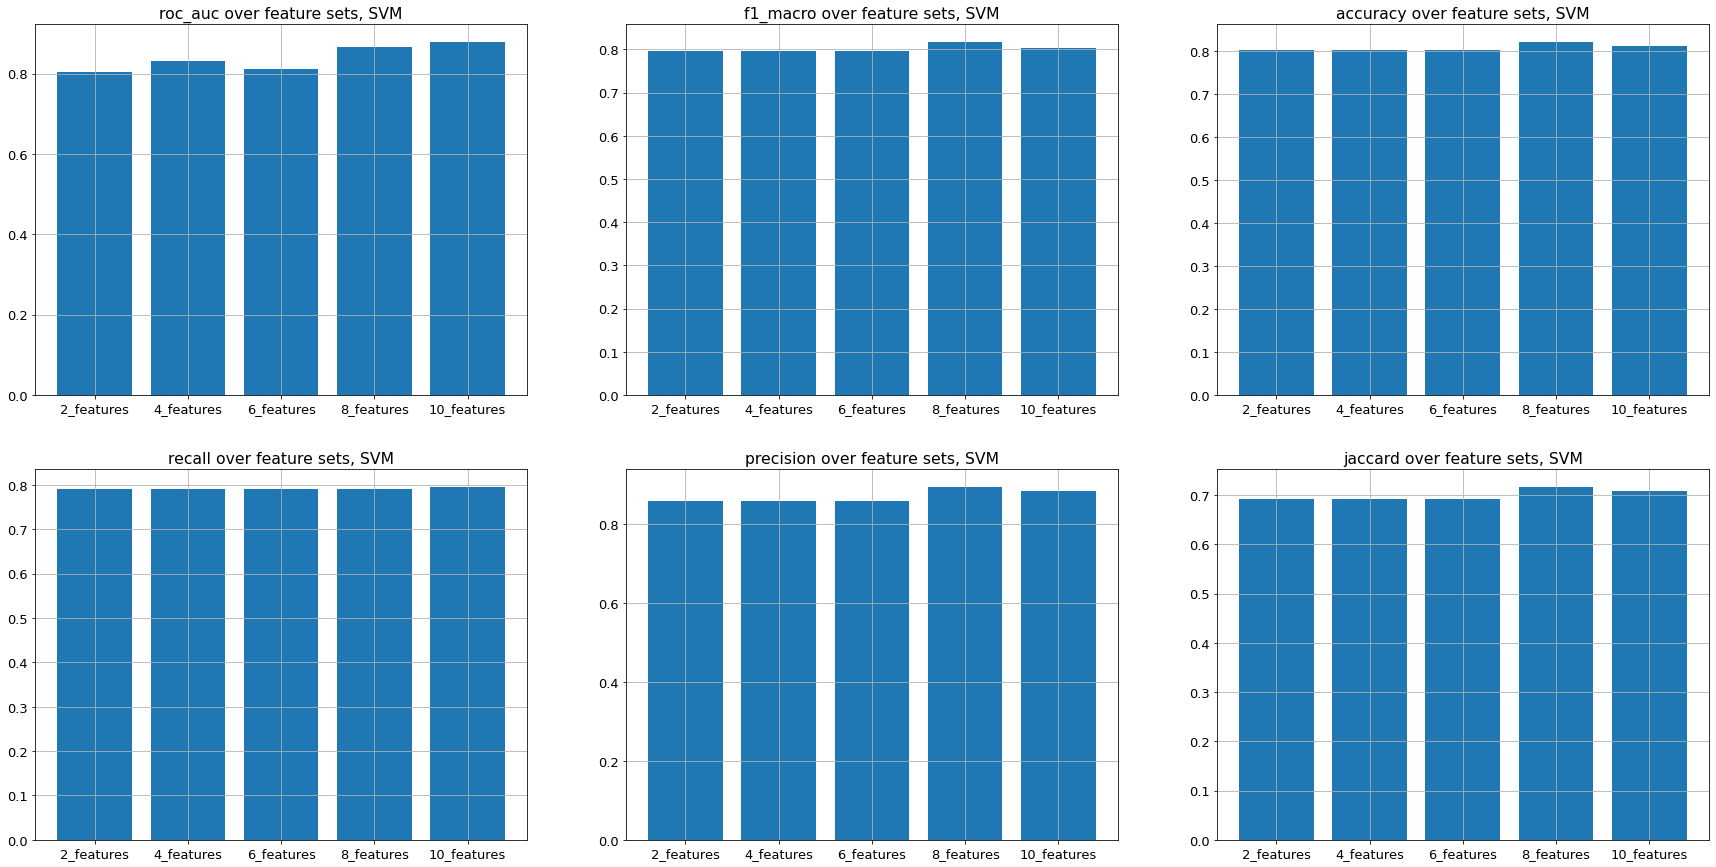

In [94]:
evaluate_model(estimator=SVC(random_state=RANDOM_STATE), params={'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1, 5, 10]}, estimator_name="SVM")

******** STARTING TRAINING AND EVALUATION OF KNN ********
Running 10-CV with features=['fasting_bs' 'exercise_angina'], estimator=KNeighborsClassifier(algorithm='brute', n_neighbors=27, p=1)
Running 10-CV with features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=KNeighborsClassifier(algorithm='ball_tree', n_neighbors=101, p=1)
Running 10-CV with features=['age' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=KNeighborsClassifier(algorithm='ball_tree', n_neighbors=101, p=1)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'max_hr' 'exercise_angina'], estimator=KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, p=1)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'resting_ecg' 'max_hr' 'exercise_angina' 'st_exercise_depression'], estimator=KNeighborsClassifier(algorithm='ball_tree', n_neighbors=101)


,2_features,4_features,6_features,8_features,10_features
roc_auc,0.8357,0.87929,0.87235,0.89883,0.90619
f1_macro,0.79695,0.79695,0.79695,0.80503,0.80526
accuracy,0.80217,0.80217,0.80217,0.81196,0.80978
recall,0.78976,0.78976,0.78976,0.81529,0.78188
precision,0.85876,0.85876,0.85876,0.86015,0.87876
jaccard,0.69241,0.69241,0.69241,0.71412,0.69739
best_hyperparameters,"{'algorithm': 'brute', 'n_neighbors': 27, 'p': 1}","{'algorithm': 'ball_tree', 'n_neighbors': 101,...","{'algorithm': 'ball_tree', 'n_neighbors': 101,...","{'algorithm': 'ball_tree', 'n_neighbors': 9, '...","{'algorithm': 'ball_tree', 'n_neighbors': 101,..."


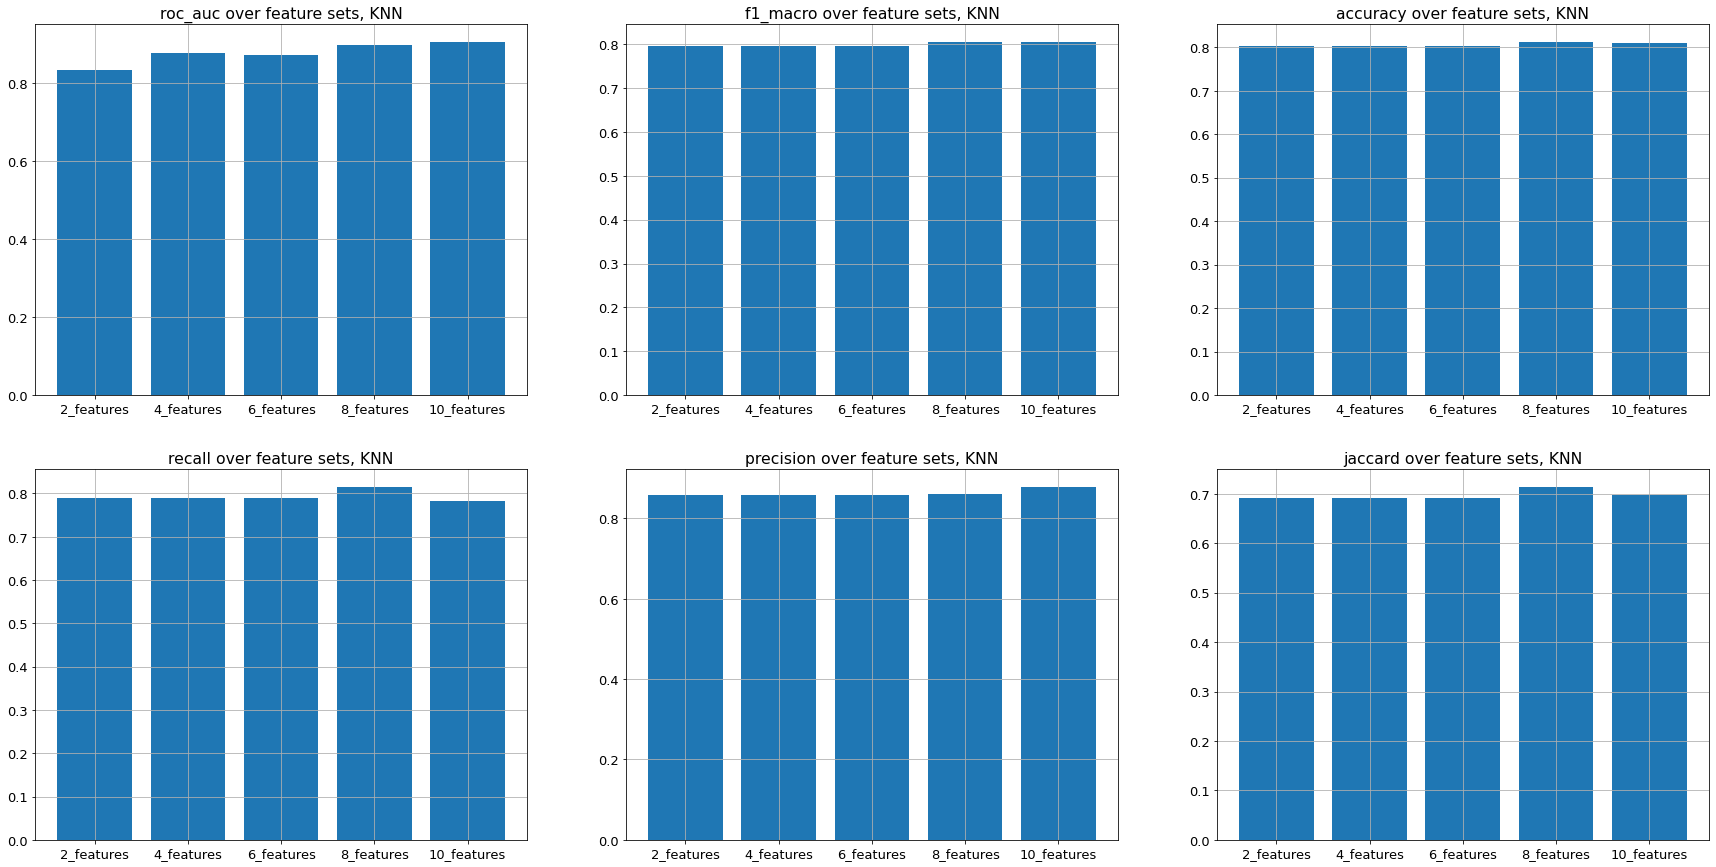

In [95]:
evaluate_model(estimator=KNeighborsClassifier(), params={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 27, 51, 101], 'algorithm': ('ball_tree', 'kd_tree', 'brute'), 'p': [1, 2]}, estimator_name="KNN")

******** STARTING TRAINING AND EVALUATION OF RF ********
Running 10-CV with features=['fasting_bs' 'exercise_angina'], estimator=RandomForestClassifier(n_estimators=1, random_state=3030)
Running 10-CV with features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=RandomForestClassifier(criterion='entropy', n_estimators=47, random_state=3030)
Running 10-CV with features=['age' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=RandomForestClassifier(n_estimators=47, random_state=3030)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'max_hr' 'exercise_angina'], estimator=RandomForestClassifier(criterion='entropy', n_estimators=23, random_state=3030)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'resting_ecg' 'max_hr' 'exercise_angina' 'st_exercise_depression'], estimator=RandomForestClassifier(criterion='entropy', n_estimators=23, random_state=3030)


,2_features,4_features,6_features,8_features,10_features
roc_auc,0.84096,0.82646,0.81636,0.87823,0.87591
f1_macro,0.79695,0.72942,0.73896,0.76741,0.77544
accuracy,0.80217,0.73913,0.75,0.77826,0.78587
recall,0.78976,0.75435,0.75831,0.78192,0.78973
precision,0.85876,0.78172,0.80701,0.8386,0.8429
jaccard,0.69241,0.61906,0.63216,0.66973,0.68173
best_hyperparameters,"{'criterion': 'gini', 'n_estimators': 1}","{'criterion': 'entropy', 'n_estimators': 47}","{'criterion': 'gini', 'n_estimators': 47}","{'criterion': 'entropy', 'n_estimators': 23}","{'criterion': 'entropy', 'n_estimators': 23}"


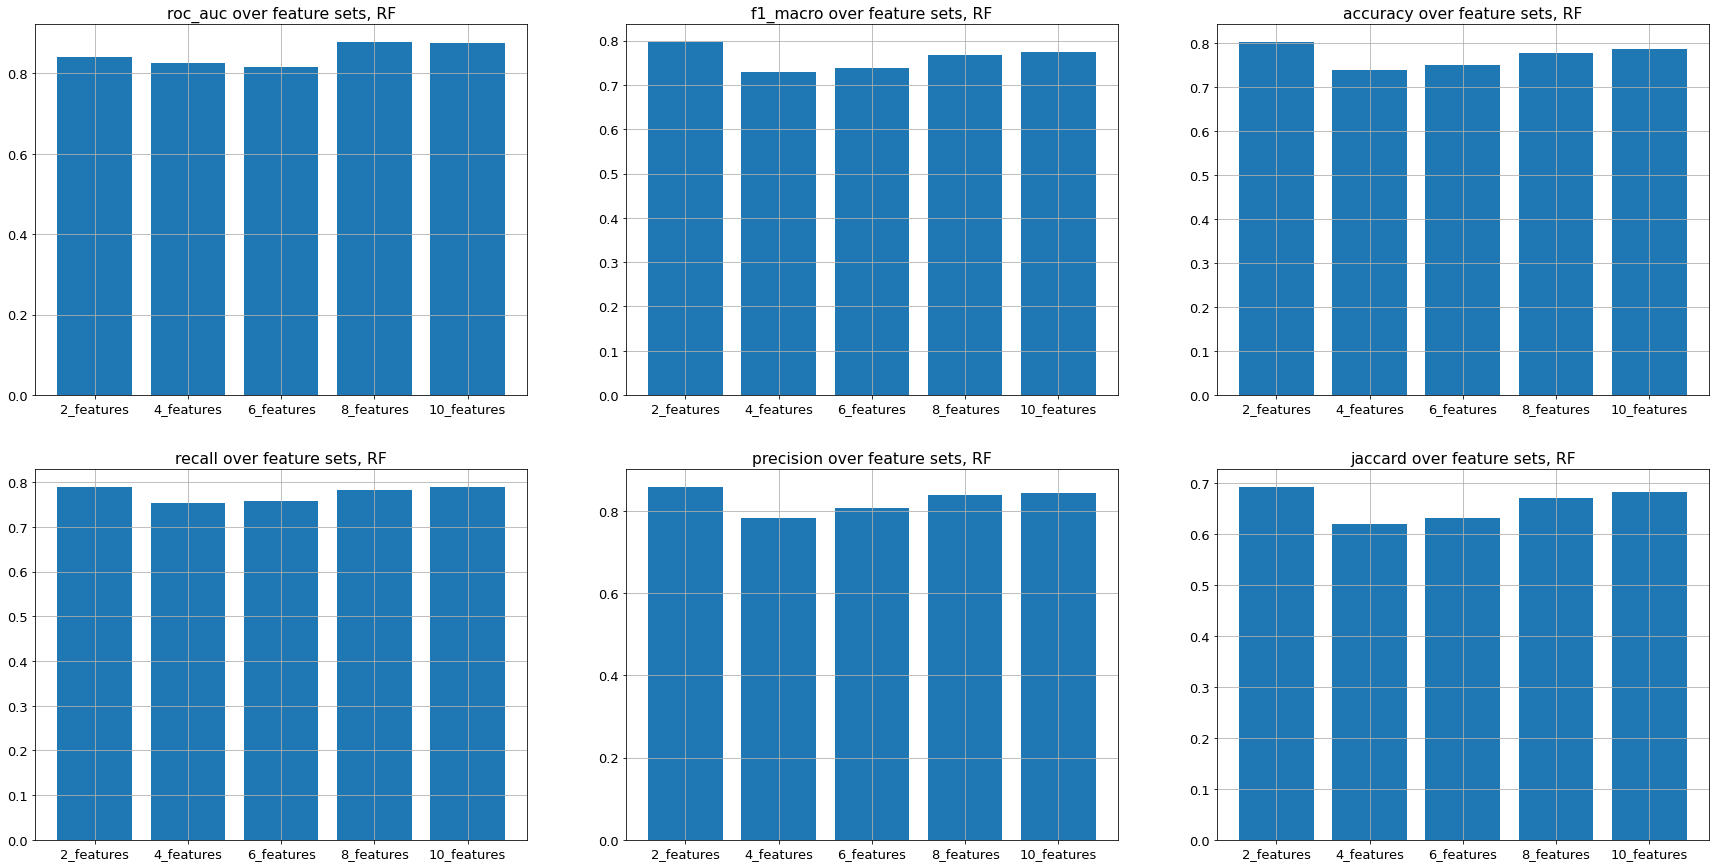

In [96]:
evaluate_model(estimator=RandomForestClassifier(random_state=RANDOM_STATE), params={'n_estimators': [1, 5, 11, 23, 47, 99], 'criterion': ('gini', 'entropy')}, estimator_name="RF")